In [1]:
!pip3 install torch torchvision
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_csv('fer2013.csv')


In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
width, height = 48, 48

images = []
lables = []
for index,row in data.iterrows():
    pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
    img=pixels.reshape((width,height))
    images.append(img)
    lables.append(row['emotion'])

In [5]:
print(len(lables))


35887


In [0]:
width, height = 48, 48

train_images = []
test_images = []
train_labels = []
test_labels = []
train_data = []
test_data = []
for index,row in data.iterrows():
    pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
    img=pixels.reshape((width,height))
    if row['Usage'] == 'Training':
      train_labels.append(row['emotion'])
      train_images.append(img)
      train_data.append(img)
      #train_data.append(row['emotion'])
    else :
      test_labels.append(row['emotion'])
      test_images.append(img)
      test_data.append(img)
      #test_data.append(row['emotion'])

for index,row in data.iterrows():
  if row['Usage'] == 'Training':
    train_data.append(row['emotion'])
  else :
    test_data.append(row['emotion'])

In [0]:

BATCH_SIZE = 512

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        #self.targets = torch.LongTensor(targets)
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
    
        if self.transform:
            #x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

    def __iter__(self):
        return self

transform = transforms.Compose([transforms.ToTensor()])#,transforms.Normalize(mean = [0.485], std=[0.229])])



In [0]:
trainset = MyDataset(train_images,train_labels, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE)#, shuffle=True, num_workers=2)

In [0]:
testset = MyDataset(test_images, test_labels, transform=transform)

testloader = DataLoader(testset, batch_size=BATCH_SIZE)#, shuffle=False, num_workers=2)

In [10]:
len(trainloader)

57

In [11]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.size()

torch.Size([512, 1, 48, 48])

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images.size()

torch.Size([512, 1, 48, 48])

In [0]:
def imshow(img):
    #img = img / 2 + 0.5     
    npimg = img.numpy()
    print(npimg.shape)
    print(np.transpose(npimg).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

(3, 3202, 402)
(402, 3202, 3)


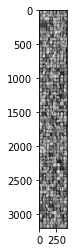

In [14]:
imshow(torchvision.utils.make_grid(images))

In [0]:
# parameters 
# N_STEPS = 48
# N_INPUTS = 48
# N_NEURONS = 48
# N_OUTPUTS = 7
# N_EPHOCS = 700

N_STEPS = 48
N_INPUTS = 48
N_NEURONS = 100
N_OUTPUTS = 7
N_EPHOCS = 100
#higher the epoches, highesr the accuracy.

In [0]:
class ImageRNN(nn.Module):
    
    
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
    
    
    def init_hidden(self,):
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) 

In [17]:
# Testing the model
      
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 48,48))
print(logits[0:6])

tensor([[-0.3252, -0.1380, -0.0477,  0.0710,  0.2662,  0.0812, -0.0957],
        [-0.2647, -0.0973, -0.0890,  0.0760,  0.3252,  0.0829, -0.1887],
        [-0.1387, -0.0142, -0.1182,  0.0436,  0.3201,  0.0514, -0.1828],
        [-0.3321, -0.1385, -0.1296,  0.0030,  0.3612,  0.0423, -0.1167],
        [-0.1945,  0.0194, -0.0979,  0.0886,  0.1002,  0.0729, -0.1440],
        [-0.2709, -0.0609, -0.1162,  0.0190,  0.2178,  0.0320, -0.1619]],
       grad_fn=<SliceBackward>)


In [0]:
# Training the model
   
import torch.optim as optim



# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
# adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [19]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0

    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 48,48) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' 
         %(epoch, train_running_loss/i, train_acc/i))
# print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' 
#           %(epoch, train_running_loss/i, train_acc/i))    


# TEST ACCURACY
test_acc = 0.0
predict = []
label = []
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 48, 48)
    
    outputs = model(inputs)
    
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    preds = torch.argmax(outputs, 1)
    pred = preds.tolist()
    lab = labels.tolist()
    predict.extend(pred)
    label.extend(lab)
    

print('Test Accuracy: %.2f'%(test_acc / i))


Epoch: 0 | Loss: 1.8400 | Train Accuracy: 25.40
Epoch: 1 | Loss: 1.7988 | Train Accuracy: 27.89
Epoch: 2 | Loss: 1.7804 | Train Accuracy: 29.15
Epoch: 3 | Loss: 1.7517 | Train Accuracy: 31.22
Epoch: 4 | Loss: 1.7410 | Train Accuracy: 32.07
Epoch: 5 | Loss: 1.7332 | Train Accuracy: 32.34
Epoch: 6 | Loss: 1.7204 | Train Accuracy: 33.14
Epoch: 7 | Loss: 1.7109 | Train Accuracy: 33.56
Epoch: 8 | Loss: 1.7090 | Train Accuracy: 33.91
Epoch: 9 | Loss: 1.7067 | Train Accuracy: 33.95
Epoch: 10 | Loss: 1.7025 | Train Accuracy: 34.15
Epoch: 11 | Loss: 1.6945 | Train Accuracy: 34.58
Epoch: 12 | Loss: 1.6931 | Train Accuracy: 34.57
Epoch: 13 | Loss: 1.6896 | Train Accuracy: 34.63
Epoch: 14 | Loss: 1.6895 | Train Accuracy: 34.68
Epoch: 15 | Loss: 1.6881 | Train Accuracy: 34.67
Epoch: 16 | Loss: 1.6878 | Train Accuracy: 34.69
Epoch: 17 | Loss: 1.6824 | Train Accuracy: 34.96
Epoch: 18 | Loss: 1.6780 | Train Accuracy: 35.17
Epoch: 19 | Loss: 1.6786 | Train Accuracy: 35.36
Epoch: 20 | Loss: 1.6765 | Tra

In [20]:
print(label)
print(predict)

[0, 1, 4, 6, 3, 3, 2, 0, 2, 0, 3, 0, 4, 2, 6, 2, 5, 0, 5, 3, 2, 5, 0, 4, 0, 2, 4, 4, 0, 2, 3, 6, 3, 6, 0, 4, 6, 2, 6, 3, 0, 4, 4, 2, 6, 3, 5, 3, 5, 6, 0, 3, 5, 4, 4, 3, 4, 2, 5, 3, 6, 3, 4, 3, 5, 3, 5, 4, 2, 6, 0, 5, 6, 6, 2, 6, 5, 6, 4, 4, 0, 0, 1, 3, 5, 4, 3, 3, 3, 3, 6, 0, 6, 4, 5, 2, 3, 3, 3, 0, 3, 6, 0, 3, 2, 3, 6, 6, 5, 3, 3, 0, 0, 2, 3, 2, 3, 6, 2, 6, 5, 0, 0, 2, 4, 6, 3, 6, 5, 5, 2, 0, 2, 6, 5, 5, 5, 6, 2, 6, 6, 3, 1, 4, 4, 6, 3, 3, 3, 2, 2, 0, 5, 3, 5, 5, 4, 5, 0, 3, 0, 3, 3, 0, 6, 6, 3, 4, 5, 3, 6, 4, 5, 6, 0, 0, 0, 4, 4, 5, 4, 3, 5, 3, 3, 0, 4, 3, 3, 3, 4, 6, 5, 5, 3, 6, 5, 6, 0, 1, 3, 6, 2, 3, 6, 2, 0, 4, 2, 2, 6, 0, 4, 4, 4, 2, 5, 4, 0, 3, 3, 4, 5, 0, 0, 3, 5, 6, 4, 3, 1, 6, 5, 2, 3, 4, 3, 0, 0, 6, 3, 6, 6, 0, 1, 3, 3, 3, 0, 6, 4, 2, 4, 3, 3, 6, 5, 4, 2, 6, 0, 1, 0, 6, 2, 0, 0, 3, 3, 4, 2, 6, 5, 3, 5, 3, 4, 5, 1, 6, 3, 3, 6, 2, 4, 0, 0, 0, 6, 2, 5, 3, 6, 4, 3, 6, 2, 6, 6, 5, 6, 4, 2, 3, 0, 3, 5, 3, 3, 3, 3, 3, 2, 6, 1, 0, 4, 2, 2, 3, 4, 2, 3, 6, 0, 4, 0, 3, 3, 5, 3, 3, 0, 

In [21]:
cm = confusion_matrix(label,predict,normalize="true")
cm

array([[0.09707724, 0.        , 0.12212944, 0.27453027, 0.2651357 ,
        0.08663883, 0.15448852],
       [0.12612613, 0.        , 0.13513514, 0.27027027, 0.23423423,
        0.07207207, 0.16216216],
       [0.06640625, 0.        , 0.15429688, 0.19921875, 0.25195312,
        0.14160156, 0.18652344],
       [0.03213078, 0.        , 0.04678692, 0.65276212, 0.12401353,
        0.04847802, 0.09582864],
       [0.05773857, 0.00080192, 0.0978348 , 0.22854852, 0.35765838,
        0.05934242, 0.19807538],
       [0.03249097, 0.        , 0.08904934, 0.1179302 , 0.10830325,
        0.55475331, 0.09747292],
       [0.04298459, 0.        , 0.08678021, 0.20519059, 0.2514193 ,
        0.06244931, 0.35117599]])

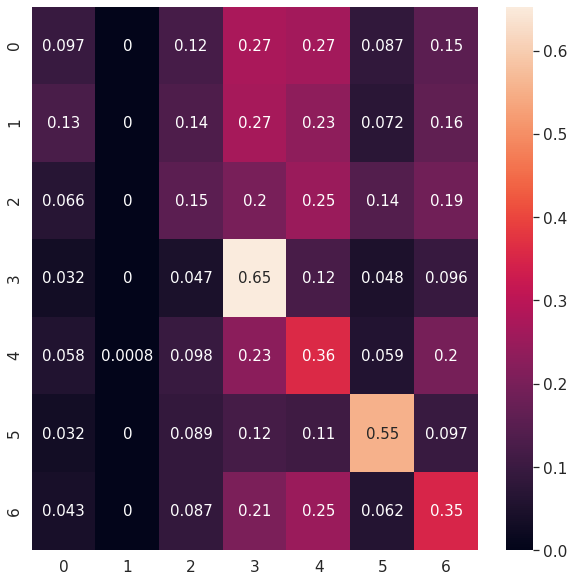

In [22]:
df_cm = pd.DataFrame(cm,range(cm.shape[0]),range(cm.shape[1]))
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15})
